# Investigating the Relationship Between Network Structure and Performance:
# A Study on Bayesian Networks and Credit Card Default

### Project report for the Fundamentals of AI and KR course - module 3
### Authors: [**Lorenzo Balzani**](mailto:lorenzo.balzani@studio.unibo.it) and [**Thomas Guizzetti**](mailto:thomas.guizzetti@studio.unibo.it)

# Abstract

The objective of this study is to explore the impact of the
structure of a Bayesian Network on its overall run-time, po-
tential unwanted bias, and accuracy in performing a classifi-
cation task.
A credit card default dataset was utilised to construct six
networks with varying structures and to learn their condi-
tional probability distributions. The resulting networks were
analysed, potential discrepancies were identified, and experi-
ments were conducted to quantify any differences.
The findings suggest that the structure of a network can sig-
nificantly impact its performance, and further studies should
focus on validating the statistical significance of the results.

This notebook should be consulted alongside its report. 

# Setup

## Requirements

In [1]:
# !pip install -q pandas numpy pgmpy

## Imports

In [2]:
from __future__ import annotations # for type annotations
import os, logging, timeit
import pandas as pd

#pygmpy
from pgmpy.base import DAG
from pgmpy.models import BayesianNetwork, NaiveBayes
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator, BayesianEstimator, ExhaustiveSearch, TreeSearch, HillClimbSearch, MmhcEstimator, BDeuScore, BicScore
from pgmpy.metrics import correlation_score, log_likelihood_score, structure_score

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score

# Viz
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

# Math
import numpy as np
from scipy.stats import norm

## Declarations

In [3]:
logger = logging.getLogger()
dataset_url = 'https://raw.githubusercontent.com/lorenzobalzani/bayesian-network-credit-cards/master/dataset.csv'
test_ratio = 0.2
random_seed = 42
print_bold = lambda string: print('\033[1m' + string + '\033[0m')

# Dataset

In [4]:
# def read_dataset(url: str) -> pd.DataFrame:
#   dataset = pd.read_csv(url, delimiter=';').set_index('ID') \
#             .rename(columns={'default payment next month': 'default'})
#   return dataset.drop(columns=[column for column in dataset.columns if 'AMT' in column]) \
#          .rename(columns={column: column.lower() for column in dataset.columns})
# 
# dataset = read_dataset(dataset_url)
# # display the dataset

dataset = pd.read_csv('dataset.csv', delimiter= ';')

In [5]:
dataset = dataset.rename(columns={'default payment next month': 'default'})
dataset = dataset.drop(columns=[column for column in dataset.columns if 'AMT' in column]) \
         .rename(columns={column: column.lower() for column in dataset.columns})

dataset

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,default
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,0,0,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,0,0,1
29998,29999,80000,1,3,1,41,1,-1,0,0,0,-1,1


## Check for missing values
No drops are needed here because the dataset is complete.

In [6]:
np.sum(pd.isnull(dataset), axis=0) # sum over the columns

id           0
limit_bal    0
sex          0
education    0
marriage     0
age          0
pay_1        0
pay_2        0
pay_3        0
pay_4        0
pay_5        0
pay_6        0
default      0
dtype: int64

## Distribution of `limit_bal` 
First, we print out the histogram related to the distribution of `limit_bal`, which is the only continuous variable used.

In [7]:
dataset.set_index('id', inplace=True)

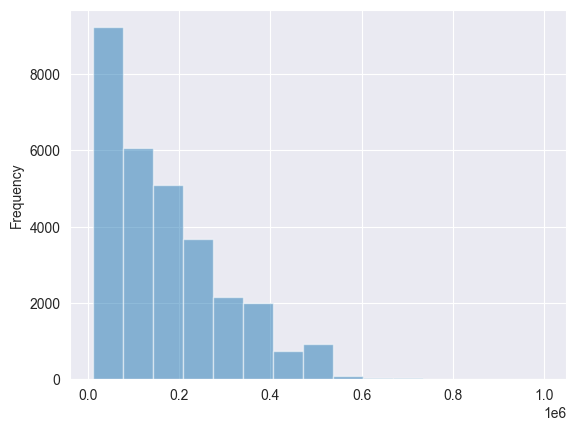

In [8]:
ax = dataset['limit_bal'].plot.hist(bins=15, alpha=0.5)

Next, we describe the distribution. To discretize it, we would like to create four beams (i.e., corresponding to the four percentiles).

In [9]:
dataset['limit_bal'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: limit_bal, dtype: float64

## Manipulation
The *artificial column* `misspayments_prev_6_months` can hold either positive, negative numbers or 0. In particular, this means: 
1. $ n = -2 $ corresponds to there was no credit to pay;
2. $ n = -1 $ corresponds to payed successfully;
3. $ n = 0 $ corresponds to a payment that was made on time but not totally to clear the balance (i.e., the minimum payment was met);
4. $ n > 0 $ corresponds to the number of delayed months.

All computations - but `misspayments_prev_6_months` - are performed in a vectorized fashion using NumPy. The less efficient alternative would have used the `apply` method over Pandas DataFrame, which internally leverages a for loop.

In [10]:
%%time

def manipulate_dataset(df: pd.DataFrame) -> pd.DataFrame:
  compute_misspayments = lambda payments_status: sum([payment_status > 0 for payment_status in payments_status])
  df['sex'] = np.where(df['sex'] == 1, 'male', 'female')
  df['marriage'] = np.where(df['marriage'] == 1, 'married', 'not_married')
  df['age'] = np.select([
              (df['age'] < 35), 
              (df['age'] >= 35) & (df['age'] < 60)],
              ['young', 'mid_aged'], default = 'senior')
  df['limit_bal'] = np.select([
                    (df['limit_bal'] < 50_000), 
                    (df['limit_bal'] >= 50_000) & (df['limit_bal'] < 140_000),
                    (df['limit_bal'] >= 140_000) & (df['limit_bal'] < 240_000)],
                    ['low', 'medium', 'medium_high'], default = 'high')
  df['education'] = np.select([
                    (df['education'] == 1), 
                    (df['education'] == 2), 
                    (df['education'] == 3)], 
                    ['graduate', 'university', 'high_school'], default = 'others') 
  df['misspayments_prev_6_months'] = df.apply(lambda row: \
                                              compute_misspayments([row[column] for column in df.columns if 'pay_' in column]), 
                                              axis=1) #axis = 1 means row by row
  return df.drop(columns=[column for column in df.columns if 'pay_' in column])

dataset = manipulate_dataset(dataset)

CPU times: user 215 ms, sys: 3.42 ms, total: 218 ms
Wall time: 219 ms


In [11]:
dataset

,limit_bal,sex,education,marriage,age,default,misspayments_prev_6_months
id,,,,,,,
1,low,female,university,married,young,1,2
2,medium,female,university,not_married,young,1,2
3,medium,female,university,not_married,young,0,0
4,medium,female,university,married,mid_aged,0,0
5,medium,male,university,married,mid_aged,0,0
...,...,...,...,...,...,...,...
29996,medium_high,male,high_school,married,mid_aged,0,0
29997,medium_high,male,high_school,not_married,mid_aged,0,0
29998,low,male,university,not_married,mid_aged,1,3


In [12]:
print(f'The dataset contains {dataset.shape[0]} rows, {dataset.shape[1]} columns and it weighs {(dataset.memory_usage(index=True, deep=True).sum() / 10**6):.2f}MB')
dataset.head()

The dataset contains 30000 rows, 7 columns and it weighs 9.17MB


,limit_bal,sex,education,marriage,age,default,misspayments_prev_6_months
id,,,,,,,
1,low,female,university,married,young,1,2
2,medium,female,university,not_married,young,1,2
3,medium,female,university,not_married,young,0,0
4,medium,female,university,married,mid_aged,0,0
5,medium,male,university,married,mid_aged,0,0


## States
Description of final dataset and its values
List - for each variable - the associated states, i.e. every possibile unique value in the domain $D$ of a random variable.

In [13]:
{col_name: column.unique() for col_name, column in dataset.items()}

{'limit_bal': array(['low', 'medium', 'high', 'medium_high'], dtype=object),
 'sex': array(['female', 'male'], dtype=object),
 'education': array(['university', 'graduate', 'high_school', 'others'], dtype=object),
 'marriage': array(['married', 'not_married'], dtype=object),
 'age': array(['young', 'mid_aged', 'senior'], dtype=object),
 'default': array([1, 0]),
 'misspayments_prev_6_months': array([2, 0, 1, 4, 5, 6, 3])}

## Train/test splitting

In [14]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('default', axis=1), dataset['default'], \
                                                    test_size=test_ratio, random_state=random_seed, \
                                                    stratify=dataset['default'])
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
print("Training set size: " + str(train.shape[0]))
print("Test set size: " + str(test.shape[0]))
print("Total size: " + str(train.shape[0] + test.shape[0]))

Training set size: 24000
Test set size: 6000
Total size: 30000


# Utility functions

## Plotting networks

In [15]:
def plot_network(network: 'DAG', name: str = 'Network', save_image: bool = False):
  fig, ax = plt.subplots(1, 1, figsize=(12, 12))
  nx.draw_networkx(network, pos=nx.drawing.layout.circular_layout(network), ax=ax, node_size=5000)
  ax.set_title(name)
  if save_image:
    fig.savefig(name)

## Parameter learning (CDPs)
Parameter are estimated given an already-defined $DAG = \{V, E\}$. The estimation is related to every random variable's *CPT*.

In [16]:
def fit_bayesian_network(bayesian_network: BayesianNetwork, prior_type: str = 'BDeu', print_cpd: bool = False) -> tuple[BayesianNetwork, list]:
  bayesian_network.fit(train, estimator=BayesianEstimator, prior_type = prior_type)
  print('The CPDs contain', 'no' if bayesian_network.check_model() else 'some', 'errors.')
  bn_cpds = bayesian_network.get_cpds()
  if print_cpd:
    TabularCPD._truncate_strtable = lambda self, x: x
    for cpd in bn_cpds:
      print(cpd)
  return bayesian_network, bn_cpds

# Hard-coded networks

## Easy

The CPDs contain no errors.


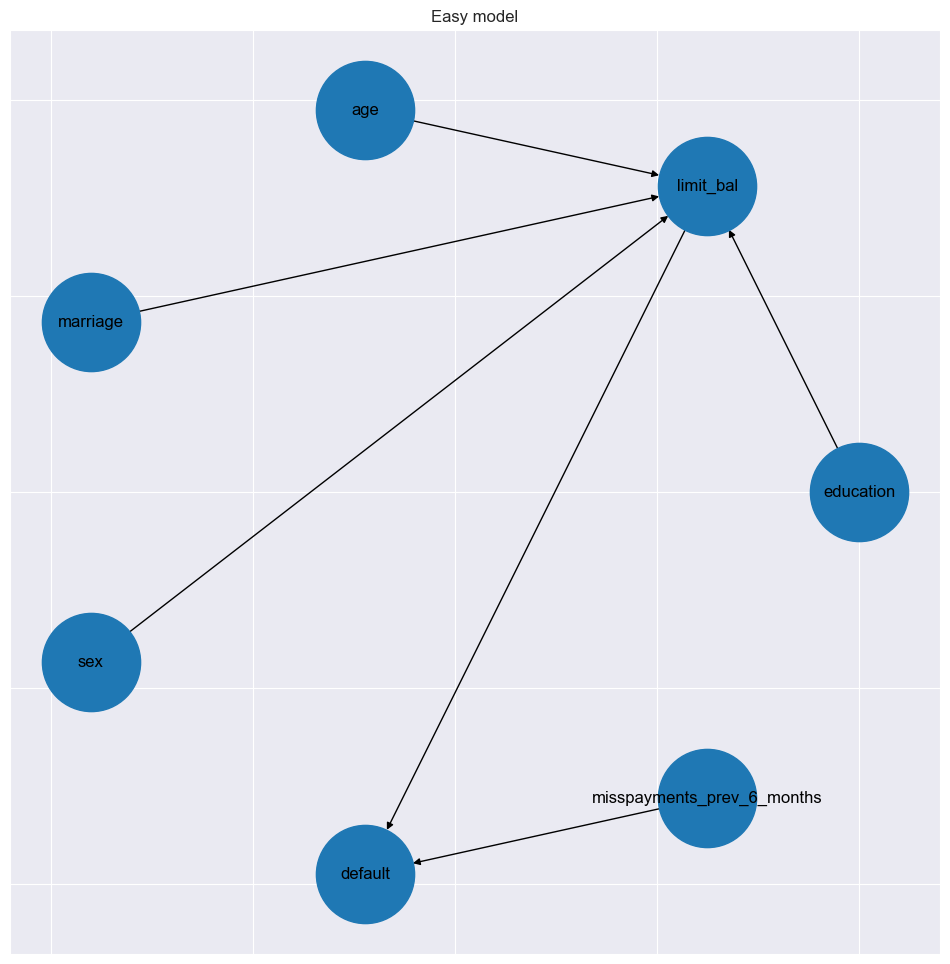

In [17]:
model_easy = BayesianNetwork([('education', 'limit_bal'), ('age', 'limit_bal'), \
                       ('marriage', 'limit_bal'), ('sex', 'limit_bal'), \
                       ('limit_bal', 'default'), ('misspayments_prev_6_months', 'default')])
plot_network(model_easy, 'Easy model')
model_easy, model_easy_cpds = fit_bayesian_network(model_easy, prior_type = 'BDeu', print_cpd = False)

## Medium

The CPDs contain no errors.


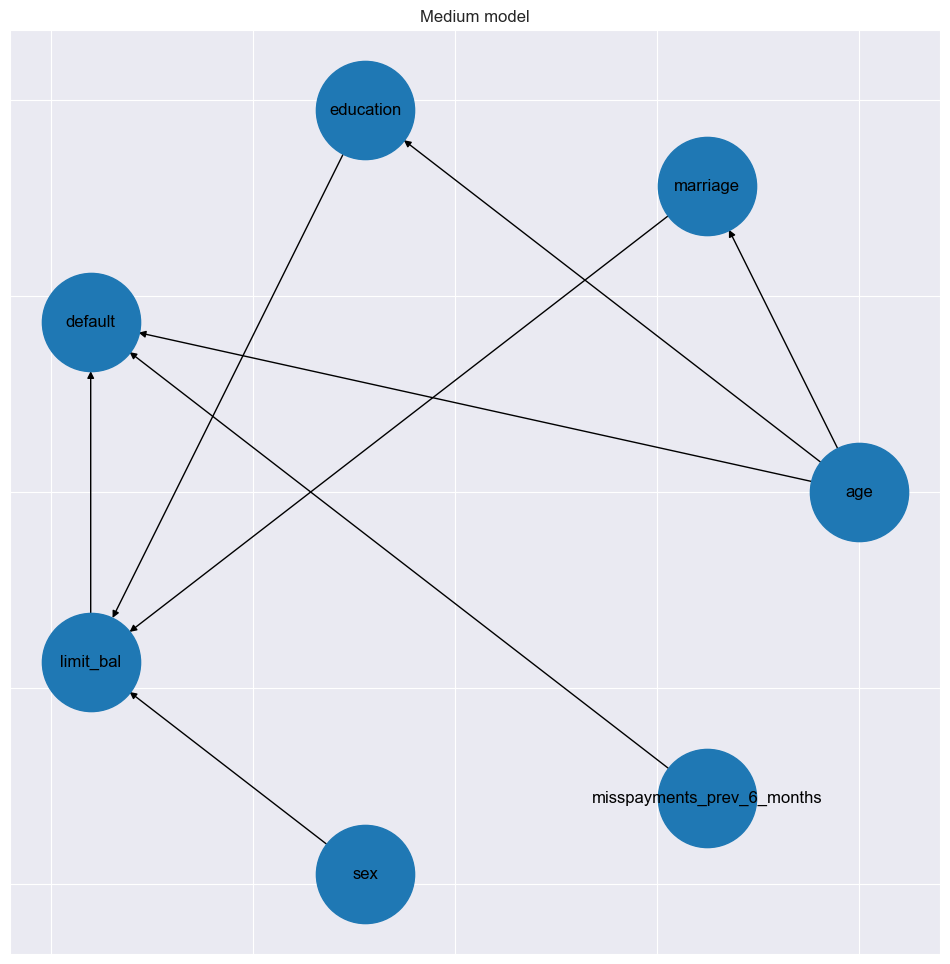

In [18]:
model_medium = BayesianNetwork([("age", "marriage"), ("age", "education"), \
                       ("age", "education"),("age", "default"), \
                       ("education", "limit_bal"), ("marriage", "limit_bal"), \
                       ("limit_bal", "default"), ("sex", "limit_bal"), \
                       ("misspayments_prev_6_months", "default")])
plot_network(model_medium, 'Medium model')
model_medium, model_medium_cpds = fit_bayesian_network(model_medium, prior_type = 'BDeu', print_cpd = False)

## Hard

The CPDs contain no errors.


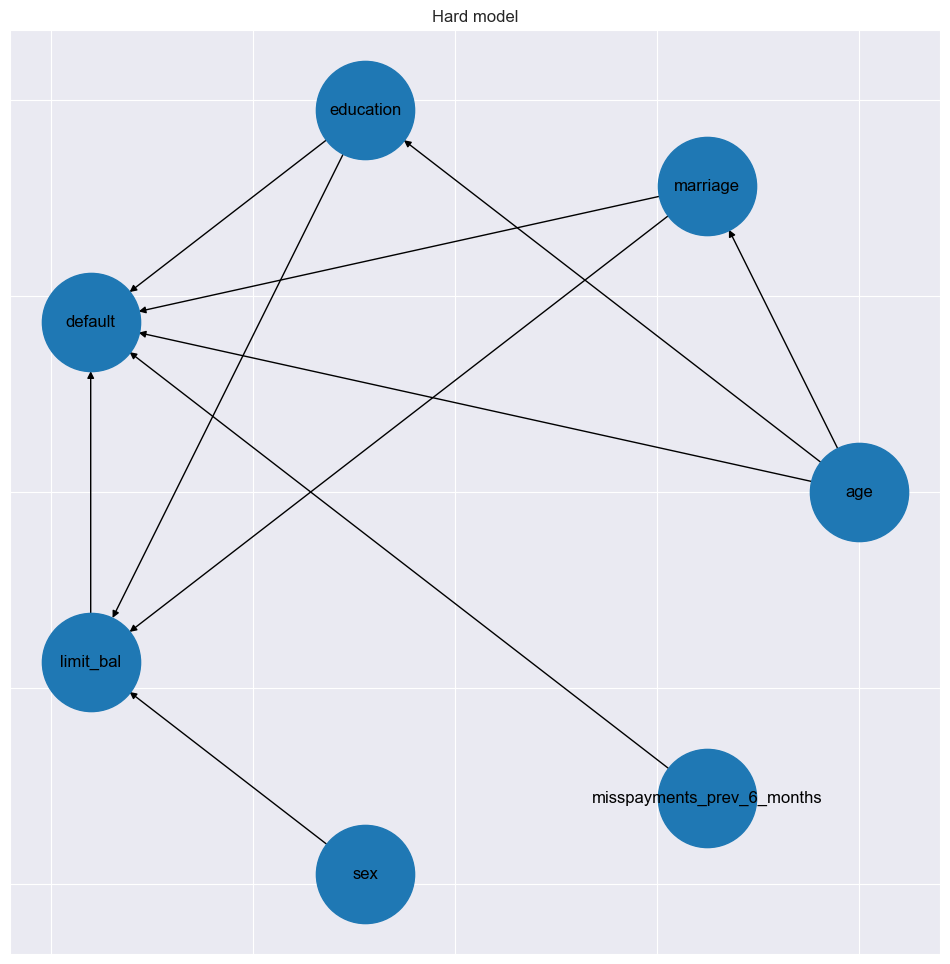

In [19]:
model_hard = BayesianNetwork([("age", "marriage"), ("age", "education"), \
                       ("age", "education"),("age", "default"), \
                       ("education", "limit_bal"), ("marriage", "limit_bal"), \
                       ("limit_bal", "default"), ("sex", "limit_bal"), \
                       ("misspayments_prev_6_months", "default"), ("education", "default"), \
                       ("marriage", "default")])
plot_network(model_hard, 'Hard model')
model_hard, model_hard_cpds = fit_bayesian_network(model_hard, prior_type = 'BDeu', print_cpd = False)

# Structural-learned models

Here we construct 3 Bayesian Networks using using the Tree Search,
Hill Climb, and Constrained Hill Climb search strategies. Exhaustive Search was considered but can not be practically executed (see below). 

## Exhaustive Search
Since the ES algorithm cost is super-exponential, it's suited only for small BN, i.e. for networks having less than 5 nodes. In our case, this method is computationally inadequate so will not be included in the networks. 

In [20]:
#ex_search = ExhaustiveSearch(data=train, scoring_method=BicScore(data=train))
#ex_search_model = ex_search.estimate()
#plot_network(ex_search_model, 'Structural Learning - Exhaustive search')
#ex_search_model = BayesianNetwork(ex_search_model.edges())
#ex_search_model, ex_search_model_cpds = fit_bayesian_network(ex_search_model, prior_type = 'BDeu', print_cpd = False)

## Tree Search

Building tree:   0%|          | 0/21.0 [00:00<?, ?it/s]

The CPDs contain no errors.


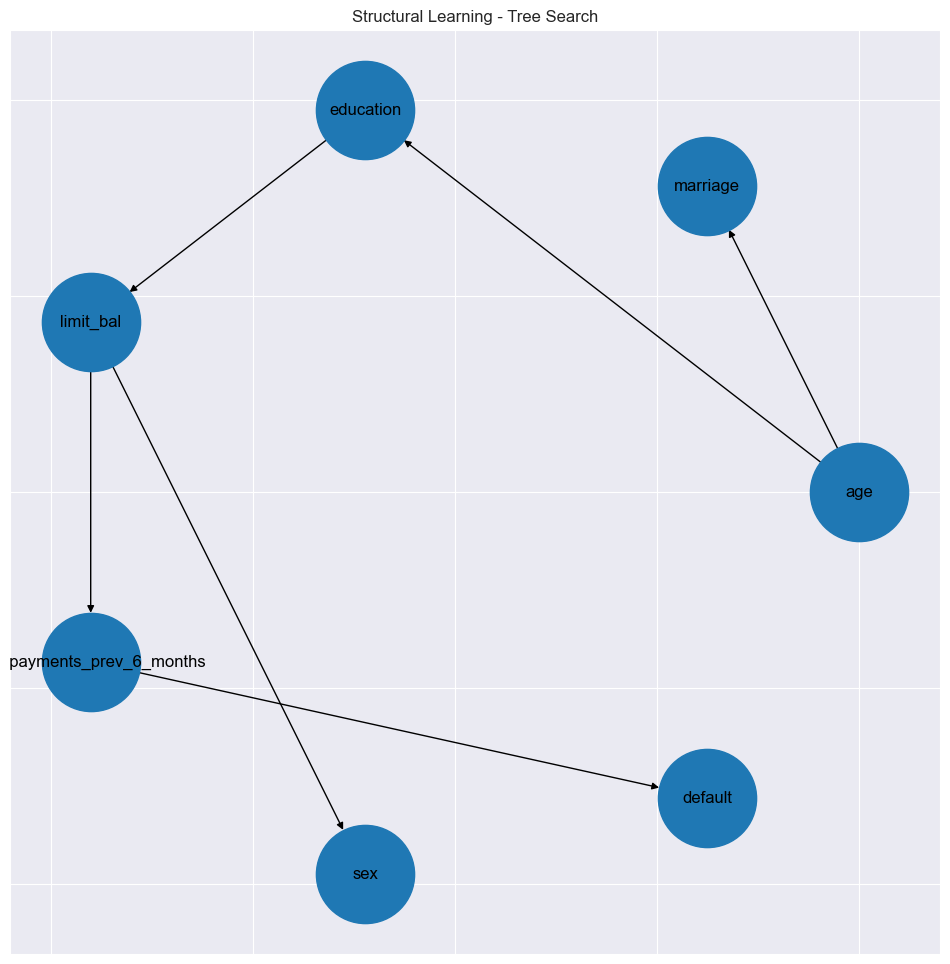

In [21]:
ts = TreeSearch(data=train, root_node='age')
tree_search_model = ts.estimate(show_progress=True)
plot_network(tree_search_model, 'Structural Learning - Tree Search')
tree_search_model = BayesianNetwork(tree_search_model.edges())
tree_search_model, tree_search_cpds = fit_bayesian_network(tree_search_model, prior_type = 'BDeu', print_cpd = False)

## Hill Climb

  0%|          | 0/1000000 [00:00<?, ?it/s]

The CPDs contain no errors.


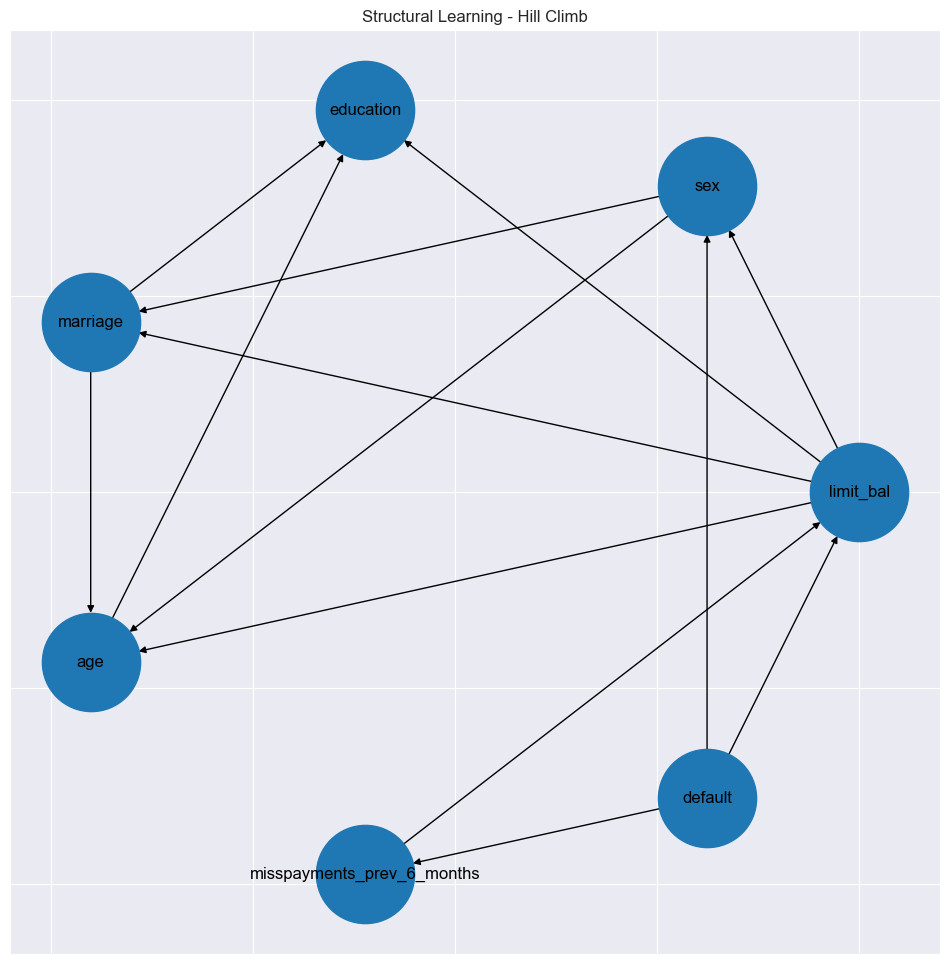

In [22]:
hill_climb = HillClimbSearch(data=train)
hill_climb_base_model = hill_climb.estimate(scoring_method=BDeuScore(data=train), show_progress=True)
plot_network(hill_climb_base_model, 'Structural Learning - Hill Climb')
hill_climb_base_model = BayesianNetwork(hill_climb_base_model.edges())
hill_climb_base_model, hill_climb_base_cpds = fit_bayesian_network(hill_climb_base_model, prior_type = 'BDeu', print_cpd = False)

## Constrained Hill Climb

  0%|          | 0/1000000 [00:00<?, ?it/s]

The CPDs contain no errors.


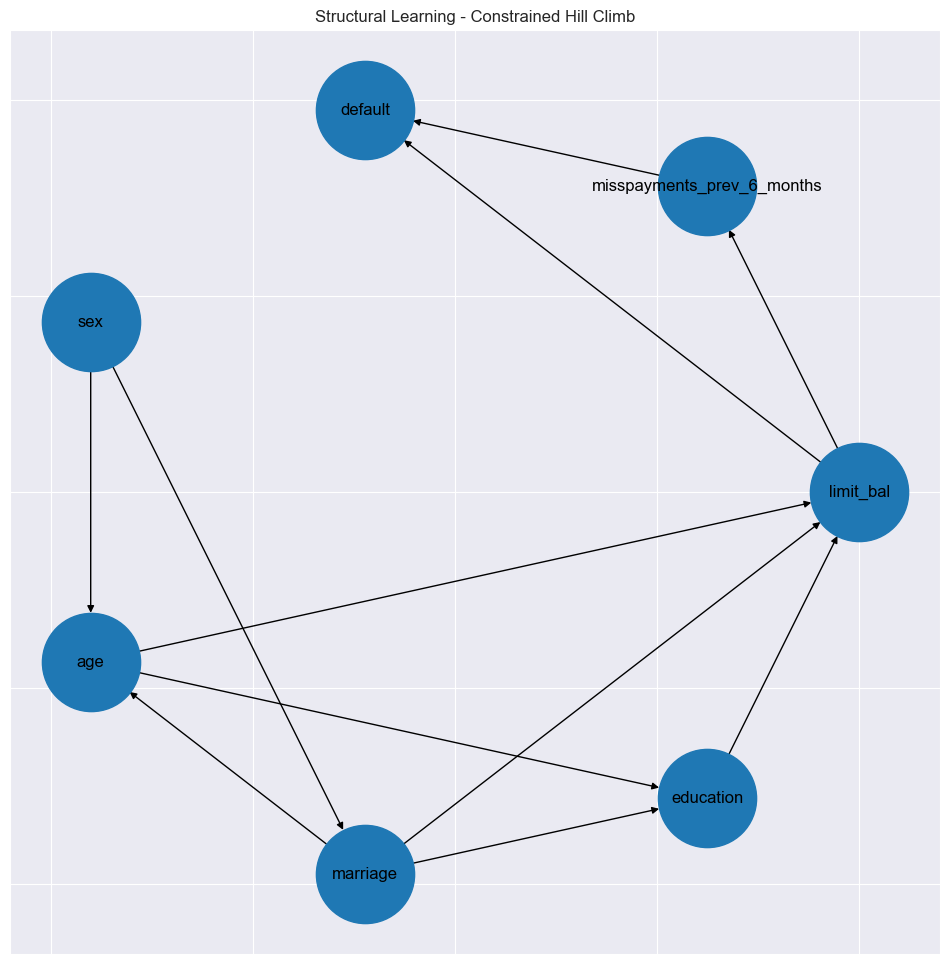

In [23]:
edges_white_list = [('misspayments_prev_6_months', 'default'), ('age','limit_bal')]
edges_black_list = [('limit_bal', 'sex'), ('education', 'sex'), ('age', 'sex')]

hill_climb = HillClimbSearch(data=train)
constr_hill_climb_model = hill_climb.estimate(scoring_method=BDeuScore(data=train), fixed_edges=edges_white_list, \
                                              black_list=edges_black_list, show_progress=True)
constr_hill_climb_model = BayesianNetwork(constr_hill_climb_model.edges())
plot_network(constr_hill_climb_model, 'Structural Learning - Constrained Hill Climb')
constr_hill_climb_model, hill_climb_constr_cpds = fit_bayesian_network(constr_hill_climb_model, prior_type = 'BDeu', print_cpd = False)

# Network analysis

We now have six differently designed Bayesian Networks with CPDs. Let's use the Pgmpy library to explore the local semantics of the networks and their Markov Blankets.

In [24]:
models = {'model_easy': model_easy, 
          'model_medium': model_medium, 
          'model_hard': model_hard, 
          'tree_search_model': tree_search_model, 
          'hill_climb_base_model': hill_climb_base_model, 
          'constr_hill_climb_model': constr_hill_climb_model}
          
nodes = [col_name for col_name, column in dataset.items()]

for model_name in models:
  print_bold(os.linesep + model_name + os.linesep)
  print_bold('Local semantics:')
  print(models[model_name].local_independencies(nodes))
  print_bold('Markov Blankets:')
  for node in nodes:
    print(f'Markov blanket of node {node}:', str(models[model_name].get_markov_blanket(node)))


model_easy

Local semantics:
(limit_bal ⟂ misspayments_prev_6_months | sex, age, marriage, education)
(sex ⟂ misspayments_prev_6_months, age, marriage, education)
(education ⟂ sex, misspayments_prev_6_months, age, marriage)
(marriage ⟂ sex, misspayments_prev_6_months, age, education)
(age ⟂ sex, misspayments_prev_6_months, marriage, education)
(default ⟂ sex, age, marriage, education | limit_bal, misspayments_prev_6_months)
(misspayments_prev_6_months ⟂ marriage, education, sex, limit_bal, age)
Markov Blankets:
Markov blanket of node limit_bal: ['misspayments_prev_6_months', 'default', 'sex', 'age', 'marriage', 'education']
Markov blanket of node sex: ['limit_bal', 'age', 'marriage', 'education']
Markov blanket of node education: ['sex', 'limit_bal', 'age', 'marriage']
Markov blanket of node marriage: ['sex', 'limit_bal', 'age', 'education']
Markov blanket of node age: ['sex', 'limit_bal', 'marriage', 'education']
Markov blanket of node default: ['limit_bal', 'misspayments_prev_6_mont

Let's see how the three characterising types of a Bayesian Network (common parent, cascade and V-structure) impact indipendencies within the networks.

__Common parent__:

In TREE SEARCH, we have that _marriage_ <- _age_ -> _education_. Hence we say that _age_ is a common parent to _marriage_ and _education_. Let's visualise the independencies that it generates:

In [25]:
print(tree_search_model.local_independencies(['age', 'marriage', 'education']))

(marriage ⟂ misspayments_prev_6_months, default, education, sex, limit_bal | age)
(education ⟂ marriage | age)


This shows how education and marriage are independent given age, which is indeed a result given by their structure in the network. Moreover, we can see that since _age_ is the only node in the Markov Blanket of _marriage_, the latter is indeed indipendent to the rest of the network given _age_.

__Cascade__:

In TREE SEARCH, we have that _age_ -> _education_ -> _limit-bal_ is a cascade. Let's visualise the independencies that it generates:

In [26]:
print(tree_search_model.local_independencies(['age', 'education', 'limit_bal']))

(education ⟂ marriage | age)
(limit_bal ⟂ age, marriage | education)


This shows that given _education_, _age_ and _limit-bal_ are independent, which is again a given in a cascade structure. 

__V-structure__:

In EASY, we can see that _limit-bal_ -> _default_ <- _misspayment-prev-6-months_. We call this a V-structure. Let's visualise once again the independencies generated: 

In [27]:
print(model_easy.local_independencies(['limit_bal', 'default', 'misspayments_prev_6_months']))

(limit_bal ⟂ misspayments_prev_6_months | sex, age, marriage, education)
(default ⟂ sex, age, marriage, education | limit_bal, misspayments_prev_6_months)
(misspayments_prev_6_months ⟂ marriage, education, sex, limit_bal, age)


We can see already that _limit-bal_ is independent to _misspayment-prev-6-months_ when default is not observed. Let's now formalise this a little by proving the below independence relationship:

* P(_limit-bal_ AND _misspayments_prev_6_months_) = P(_limit-bal_) * P(_misspayments_prev_6_months_)

* P(_limit-bal_ AND _misspayments_prev_6_months_ | _default_) != P(_limit-bal_ | _default_) * P(_misspayments-prev-6-months_ | _default_)


In [28]:
print("P(limit-bal AND misspayments-prev-6-months) = P(limit-bal) * P(misspayments_prev_6_months) is " + \
      str(VariableElimination(model_easy).query(["misspayments_prev_6_months", "limit_bal"]) == \
      VariableElimination(model_easy).query(["limit_bal"]) * VariableElimination(model_easy).query(["misspayments_prev_6_months"])))

print("P(limit-bal AND misspayments-prev-6-months | default) = P(limit-bal | default) * P(misspayments_prev_6_months | default) is " + \
      str(VariableElimination(model_easy).query(["misspayments_prev_6_months", "limit_bal"], {"default":0}) == \
      VariableElimination(model_easy).query(["limit_bal"], {"default":0}) * VariableElimination(model_easy).query(["misspayments_prev_6_months"], {"default":0})))

P(limit-bal AND misspayments-prev-6-months) = P(limit-bal) * P(misspayments_prev_6_months) is True
P(limit-bal AND misspayments-prev-6-months | default) = P(limit-bal | default) * P(misspayments_prev_6_months | default) is False


Indeed we have that limit_bal is independent to misspayments_prev_6_months when default is not observed, while limit_bal is conditionally dependent to misspayments_prev_6_months when default is observed.

__Compactness__

The compactness of a Bayesian network is a measure of how efficiently the network represents the joint probability distribution over its variables. A more compact network requires fewer parameters to represent the same joint distribution, which can be beneficial for both computational efficiency and interpretability.

One common measure of compactness is the number of independent parameters required to specify the network. A more compact network requires fewer independent parameters.

Another measure of compactness is the "treewidth" of the network, which is a measure of how "tree-like" the network is. The treewidth of a network is defined as the minimum width of a tree decomposition of the network. A tree decomposition is a collection of subsets of nodes in the network such that every node in the network is included in at least one subset, and every edge in the network is included in at least one subset. The width of a tree decomposition is defined as the size of the largest subset minus 1. The treewidth of the network is the minimum width over all possible tree decompositions.

For the purpose of this study, we will consider the number of independent parameters as the measure of compactness of the network. 

Below, we compile a function that calculates the number of independent parameters of each of our models:

In [29]:
from numpy import prod
from pgmpy.models import BayesianModel

def calculate_independent_parameters(bn):
    """
    Calculates the number of independent parameters required to define the conditional probability
    distribution of all nodes in a Bayesian network.

    Parameters:
        bn (pgmpy.models.BayesianModel): A Bayesian network model.

    Returns:
        The number of independent parameters required to define the conditional probability
        distribution of all nodes in the Bayesian network.
    """
    # Initialize the total number of independent parameters
    num_independent_params = 0

    # Iterate over each node in the network
    for node in bn.nodes():
        node_cardinality = len(bn.get_cpds(node).state_names[node])
        parent_cardinalities = [len(bn.get_cpds(parent).state_names[parent]) for parent in bn.predecessors(node)]
        num_parents_states = parent_cardinalities[0] if len(parent_cardinalities) == 1 else prod(parent_cardinalities)
        num_independent_params += (node_cardinality - 1) * num_parents_states

    return int(num_independent_params)

In [30]:
print(f"Number of indipendent parameters required to describe CPDs for model_easy is: {calculate_independent_parameters(model_easy)}")
print(f"Number of indipendent parameters required to describe CPDs for model_medium is: {calculate_independent_parameters(model_medium)}")
print(f"Number of indipendent parameters required to describe CPDs for model_hard is: {calculate_independent_parameters(model_hard)}")
print(f"Number of indipendent parameters required to describe CPDs for tree_search_model is: {calculate_independent_parameters(tree_search_model)}")
print(f"Number of indipendent parameters required to describe CPDs for hill_climb_base_model is: {calculate_independent_parameters(hill_climb_base_model)}")
print(f"Number of indipendent parameters required to describe CPDs for constr_hill_climb_model is: {calculate_independent_parameters(constr_hill_climb_model)}")

Number of indipendent parameters required to describe CPDs for model_easy is: 185
Number of indipendent parameters required to describe CPDs for model_medium is: 153
Number of indipendent parameters required to describe CPDs for model_hard is: 741
Number of indipendent parameters required to describe CPDs for tree_search_model is: 61
Number of indipendent parameters required to describe CPDs for hill_climb_base_model is: 175
Number of indipendent parameters required to describe CPDs for constr_hill_climb_model is: 153


# Experiment #1: Overall Run-Time

Let's measure the overall run-time of a model by calculating how long it takes to calculate all the possible queries that can be executed using each network. 
The queries are computed using an exact inference method, namely Variable Elimination. 



We use %%timeit to measure the cell run-time and use the output as the overall run-time of the network.



In [31]:
def run_all_queries(model):

  from pgmpy.inference import VariableElimination

  def all_subsets(ss):
      if len(ss) == 0:
          return [[]]
      else:
          result = []
          for subset in all_subsets(ss[1:]):
              result.append(subset)
              result.append([ss[0]] + subset)
          return result
          
  # VariableElimination
  ve = VariableElimination(model)

  # Get the list of all variables in the network
  all_variables = list(model.nodes)

  # Calculate the runtime of every possible query
  for query_vars in all_subsets(all_variables):
      query_result = ve.query(variables=query_vars)

In [32]:
%%timeit -r 10 -n 100
run_all_queries(model_easy)

/Users/bses/F1_Intern/bayesian-network-credit-cards-master/.venv/lib/python3.12/site-packages/pgmpy/inference/ExactInference.py:763: SyntaxWarning: invalid escape sequence '\s'
  """


KeyboardInterrupt: 

In [ ]:
%%timeit -r 10 -n 100
run_all_queries(model_medium)

In [ ]:
%%timeit -r 10 -n 100
run_all_queries(model_hard)

In [ ]:
%%timeit -r 10 -n 100
run_all_queries(tree_search_model)

In [ ]:
%%timeit -r 10 -n 100
run_all_queries(hill_climb_base_model)

In [ ]:
%%timeit -r 10 -n 100
run_all_queries(constr_hill_climb_model)

# Experiment #2: Bias

Let's analyse how the different models infer two queries. In particular, let's look at the below conditional probabilities:

*   Probability of sex given marriage.
*   Probability of default given sex.

The purpose of these queries is to 1) determine whether the same queries might return different results for the different networks and to 2) explore the possibility of the networks carrying a bias (in this case if sex influences the probability of credit card default) given their structure. 

We will compare the different structures using our `inference_score` function, which in our case will compute the difference of the resulting percentage of $P(Default|Male)$ and $P(Default|Female)$ respectively for each network.








In [ ]:
def inference_score(query_desc: str, query: list, evidence: list):
  evidence_values = dataset[evidence[0]].unique()
  impact_on_model = {}
  for model_name in models:
    result = []
    data_infer = VariableElimination(models[model_name])
    for value in evidence_values:
      result.append(data_infer.query(query, {evidence[0]: value}).values[0])
    impact_on_model[model_name] = (max(result) - min(result))/((max(result) + min(result)) / 2) * 100
  return impact_on_model

Let's now perform the same queries across the different networks and comment the results.

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(rotation=60)
inference_df = inference_score('Difference(%) of probability of individual being male or female given marital status, per model', ['sex'], ['marriage'])
sns.barplot(x = list(inference_df.keys()), y=list(inference_df.values()) , palette='pastel').set(title='Difference(%) of probability of individual being male or female given marital status, per model')

We can see from the plot that sex is not influenced by marriage status in the hard-coded networks and instead in the networks learned from data we see that the probability of sex given married or not married status changes by around 0.1% for the Tree Search model and around 4% for the Hill Climb ones. 

There is an explanation for this. Indeed, for the network learned from data there is an active trail from marriage node to sex node given marriage. Instead for the hard-coded ones the marriage and sex nodes are part of a v-structure, in which they are both parents. Hence the nodes sex and marriage are independent of one another if the common child is not given in the evidence (as mentioned before in the network analysis), which is the case here. 

If limit_bal was given as evidence, we would however see a difference in the query.

In [ ]:
def inference_score_given_limit_bal(query_desc: str, query: list, evidence: list):
  evidence_values = dataset[evidence[0]].unique()
  impact_on_model = {}
  for model_name in models:
    result = []
    data_infer = VariableElimination(models[model_name])
    for value in evidence_values:
      result.append(data_infer.query(query, {evidence[0]: value, 'limit_bal': 'low'}).values[0])
    impact_on_model[model_name] = (max(result) - min(result))/((max(result) + min(result)) / 2) * 100
  return impact_on_model

sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(rotation=60)
inference_given_limit_bal_df = inference_score_given_limit_bal('Difference(%) of probability of individual being male or female given marital status and limit_bal, per model', ['sex'], ['marriage'])
sns.barplot(x = list(inference_given_limit_bal_df.keys()), y=list(inference_given_limit_bal_df.values()) , palette='pastel').set(title='Difference(%) of probability of individual being male or female given marital status and limit_bal, per model')

We indeed see that given limit_bal we have a change in probability of sex given marital status and limit_bal. Moreover, we see that given limit_bal, there is no change in the Tree Search model - this is because in the Tree Search model sex, limit_bal and marriage are in cascade, and limit_bal is a child node of marriage and a parent node of sex. 

We notice here that the probability of guessing the sex of an individual given other attributes seems to be varying quite a lot depending on the model.
Given that this data represents very sensitive financial data, we want to avoid any sort of bias against sex and it seems as if the networks have different bias intrinsic to their structure.  

In [ ]:
pd.DataFrame.from_dict(inference_score('How much is default impacted by sex?', ["default"], ['sex']), orient='index')

#This reiterates that it's important to add constraits to a network learned by data as it obviously doesn't take in cosideration the context of the data itself. 
#The constraint_hill_climb model is the model that has the least bias towards sex, as sex has the lowest impact on

sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(rotation=60)
inference_df = inference_score('Difference(%) of probability of individual being male or female given marital status and limit_bal, per model', ['default'], ['sex'])
sns.barplot(x = list(inference_df.keys()), y=list(inference_df.values()) , palette='pastel').set(title='Difference(%) of probability of default given an individual being male or female, per model')

We can see clearly that hill_climb_base_model_ seems to be heavily biased against sex, in particular probability of credit card default is heavily influenced by sex. 

These findings imply that any conclusions drawn from the Hill-
Climb Base model should be interpreted with caution as it may result in unintended bias. Specifically, this high-lights the necessity of imposing constraints on the model to generate a fairer network.

# Experiment #3: Classification Tasks
So far, the models have been evaluated only in a qualitative manner. In particular, a domain expert can reasonably tell if the results are good enough. 

The next step is to evaluate the model quantitatively. We will hence perform a classification task over the dataset to predict credit card default and we will use accuracy, F1/F2, precision, and recall metrics to compare how each network performs. 

In [ ]:
def predict(data_point: dict, inference_object: VariableElimination, query: str) -> tuple[float, float]:
  result = inference_object.query(variables=['default'], evidence=dict(data_point))
  values = result.state_names[query]
  default = np.argmax(result.values)
  return default, result.values # outcome, classes probs

def predict_batch(batch: pd.DataFrame, inference_object: VariableElimination, query: str) -> list[int]:
  return [predict(data_point[1], inference_object, query)[0] for data_point in batch.iterrows()]

In [ ]:
metrics = {model_name: None for model_name in models}

for model_name in metrics:
  preds = predict_batch(X_test, VariableElimination(models[model_name]), query = 'default')
  metrics[model_name] = {'accuracy': accuracy_score(y_test, preds), 
                         'recall': recall_score(y_test, preds), 
                         'f1_score': f1_score(y_test, preds)}
  print_bold(model_name)
  for metric, value in metrics[model_name].items():
    print(f'{metric}: {value:.2%}')

## Are these results statistically different?
We can see from the below statistical inquiry on the results of the classification task that some of the model appear to perform with statistically significant difference. 

To compute their differences we used our `compare_two_models` function, that outputs a range $[a, b]$. 
In particular, if 0 $\in [a,b]$, there is no statistical difference between the models with confidence $c$.

In [ ]:
def diff_interval(a1, a2, N1, N2, Z):
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd

def compare_two_models(score1: float, score2: float, len_dataset, c: float = 0.95):
    Z = norm.ppf((1 + c) / 2)
    return diff_interval(score1, score2, len_dataset, len_dataset, Z)

In [ ]:
comparison = np.empty((len(models), len(models)))

for i, model_name in enumerate(metrics):
  for j, inner_model_name in enumerate(metrics):
    range = compare_two_models(metrics[model_name]['f1_score'], metrics[inner_model_name]['f1_score'], len(X_test))
    comparison[i][j] = 0 if range[0] < 0 else 1

print_in_cell = lambda *values: '\n'.join([*values])

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(comparison, \
                annot = np.array([[print_in_cell('Stat.', 'equivalent') if item == 0 else print_in_cell('Stat.', 'different') for item in row ] for row in comparison]), \
                xticklabels=models, yticklabels=models, mask=np.triu(np.ones_like(comparison, dtype=bool), k=1), \
                fmt='', center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5}, cbar=False)
ax.set(xlabel='Models', ylabel='Models')